## Bot 4 Logic
The expression that represents the probability of a given cell being set on fire is:
$$
1-(1-q)^K
$$
where
$q = \text{ship flammability,}$
$K = \text{number of on-fire neighbors.}$

Our approach for Bot 4 will be an implementation of Dijkstra's Shortest-Path Algorithm in which our cost function will take in a given cell's probability of being set on fire several steps in advance. There are a few ways to perform this:
1. Markov Chain Monte Carlo Method: Before starting the algorithm, simulate the fire spreading throughout the grid $n$ times. Create a dataframe that records each open cell and which timestep $t_i$ for $i=1,...,n$ it was set on fire, with cells as rows and simulations as columns. We will be able to estimate the likelihood of a given cell being on fire by a given timestep by taking the rate of being on fire out of all simulations (shown below). This will give an estimate for the true distribution of probabilities for each cell. Then, when running Dijkstra's, when considering a cell for exploration, we take into account its calculated probability.
2. For each iteration of Dijkstra's, given a cell being considered, mathematically calculate its probability that it will be set on fire by a certain timestep. This is possible but would be more expensive than simulation.

We will choose option 1 with cost function $$C(node)=\alpha * p(\text{node on fire}|t)+\beta * d$$ 
where 
$$\alpha = \text{scaling factor for } p,$$
$$p(\text{node on fire}|t)=\frac{1}{n}\sum_{i=1}^{n} 1 (t_i\leq t),$$
$$\beta = \text{scaling factor for } d,$$
$$d=\text{Manhattan distance from node to button.}$$

Note that using the Manhattan distance is a relaxation of the problem, as it assumes that every cell between the bot and the button is open.

Also note that the coefficients $\alpha$ and $\beta$ allow us to quantify how risk-averse we want to be. Early on, the algorithm will prioritize low-risk cells; later on, the algorithm will prioritize closer cells to the button. After trial and error, we choose $\alpha = 5$ and $\beta = 0.5$.

## Building the Ship

In [1]:
import random

d = 40

#Helper method to check neighbors in board initialization
def checkNeighbors(grid, r, c, a):
    return [grid[r-1][c],grid[r+1][c],grid[r][c-1],grid[r][c+1]].count(a)

#Create new board with given edge length
def createBoard(d):
    grid = [[0 for _ in range(d+2)] for _ in range(d+2)]

    for j in range(d+2):
        grid[0][j] = 2 
        grid[d+1][j] = 2 
    for i in range(d+2):
        grid[i][0] = 2 
        grid[i][d+1] = 2
    x = random.randint(1, d)
    y = random.randint(1, d)

    fringe = []
    fringe.append((x,y))

    deadEnds = []

    while len(fringe) > 0:
        curr = random.choice(fringe)
        fringe.remove(curr)
        r, c = curr[0], curr[1]
        if checkNeighbors(grid, r, c, 1) > 1:
            continue
        grid[r][c] = 1
        up = (r-1, c) 
        down = (r+1, c) 
        left = (r, c-1) 
        right = (r, c+1)
        deadEnd = True
        for elt in [up, down, left, right]:
            if grid[elt[0]][elt[1]] == 0:
                numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
                if numOpenNeighbors == 1:
                    deadEnd = False
                    fringe.append(elt)
        if deadEnd:
            deadEnds.append(curr)
    
    for elt in deadEnds:
        if grid[elt[0]][elt[1]] == 2:
            deadEnds.remove(elt)
            continue
        numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
        if numOpenNeighbors > 1:
            deadEnds.remove(elt)

    newList = random.sample(deadEnds, len(deadEnds) // 2)
    for elt in newList:
        r = elt[0]
        c = elt[1]
        up = (r-1, c) 
        down = (r+1, c) 
        left = (r, c-1) 
        right = (r, c+1)
        neighbors = [up,down,left,right]
        neighbors = [elt for elt in neighbors if grid[elt[0]][elt[1]] == 0]
#         for pt in neighbors:
#             if (pt[0] < 1 or pt[0] > 40) or (pt[1] < 1 or pt[1] > 40):
#                 neighbors.remove(pt)
#             if grid[pt[0]][pt[1]] == 1:
#                 neighbors.remove(pt)
#     #     print(neighbors)
        if neighbors == []:
            continue
        curr = random.choice(neighbors)
#         while grid[curr[0]][curr[1]] == 2:
#             print(curr)
#             curr = random.choice(neighbors)
        grid[curr[0]][curr[1]] = 1
        
#     count = 0   
#     for row in grid:
#         count += row.count(1)
#     print(f"Percent of cells opened: {100*count/(d*d)}")
    return grid

board implementation details here if youd like

In [2]:
grid = createBoard(d)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

color_map_3 = {
    0: 'white',
    1: 'black',
    2: 'red'
}

color_map_7 = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

def visualizeGrid(color_map, grid):
    fig, ax = plt.subplots()

    for i in range(len(grid)):
        for j in range(len(grid[i])):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

    ax.set_xlim(0, len(grid[0]))
    ax.set_ylim(0, len(grid))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    plt.gca().invert_yaxis() 
    plt.show()

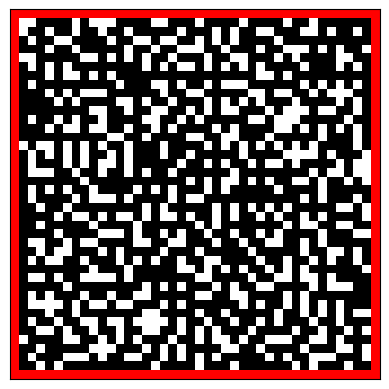

In [4]:
visualizeGrid(color_map_3, grid)

black = open cells, red = wall

## Coding the Fire


In [5]:
def setFire(grid, pt, q):
    if grid[pt[0]][pt[1]] == 3:
        return
    k = checkNeighbors(grid, pt[0], pt[1], 3)
    prob = 1 - (1-q)**k
    x = random.random()
    if x <= prob:
        grid[pt[0]][pt[1]] = 3
    return

In [6]:
def spreadFire(grid, fireLocs, q, df=None, i=None, timestep=None):
    fireLocsNew = []
    for curr in fireLocs:
        if grid[curr[0]][curr[1]] == 2:
            fireLocs.remove(curr)
            continue
        setFire(grid, curr, q)
        if grid[curr[0]][curr[1]] == 3:
            fireLocs.remove(curr)
            if df is not None and i is not None and timestep is not None:
                df.loc[curr][i] = timestep
            neighbors = [(curr[0]-1,curr[1]), (curr[0]+1,curr[1]), (curr[0], curr[1]-1), (curr[0], curr[1]+1)]
            for elt in neighbors:
                if grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4:
                    fireLocsNew.append(elt)
    fireLocs.extend(fireLocsNew)
    return fireLocs

In [7]:
def reset_grid(grid):
    for i in range(len(grid)):  # Iterate through rows
            for j in range(len(grid[i])):  # Iterate through columns
                if (grid[i][j] in range(3,7)):
                    grid[i][j] = 1
#     grid[fireLoc[0]][fireLoc[1]] = 3

## Location Initializations

In [8]:
def location_initialization(grid, botLoc=None, butLoc=None, fireLoc=None):
    botLoc = (random.randint(1, d), random.randint(1, d))
    while grid[botLoc[0]][botLoc[1]] == 0:
        botLoc = (random.randint(1, d), random.randint(1, d))

    butLoc = (random.randint(1, d), random.randint(1, d))
    while grid[butLoc[0]][butLoc[1]] == 0:
        butLoc = (random.randint(1, d), random.randint(1, d))

    fireLoc = (random.randint(1, d), random.randint(1, d))
    while grid[fireLoc[0]][fireLoc[1]] == 0:
        fireLoc = (random.randint(1, d), random.randint(1, d))

    notDistinct = (botLoc == butLoc) or (botLoc == fireLoc) or (butLoc == fireLoc)
    #print(distinct)
    i = 1
    while notDistinct:
#         print(i)
        botLoc = (random.randint(1, d), random.randint(1, d))
        while grid[botLoc[0]][botLoc[1]] == 0:
            botLoc = (random.randint(1, d), random.randint(1, d))
        butLoc = (random.randint(1, d), random.randint(1, d))
        while grid[butLoc[0]][butLoc[1]] == 0:
            butLoc = (random.randint(1, d), random.randint(1, d))
        fireLoc = (random.randint(1, d), random.randint(1, d))
        while grid[fireLoc[0]][fireLoc[1]] == 0:
            fireLoc = (random.randint(1, d), random.randint(1, d))
        i = i + 1
        notDistinct = (botLoc == butLoc) or (botLoc == fireLoc) or (butLoc == fireLoc)
    
    return botLoc,butLoc,fireLoc

note - for every new board we create we need to run createboard AND location_initialization

In [9]:
botLoc,butLoc,fireLoc = location_initialization(grid)
print(f"Bot Location: {botLoc}")
print(f"Button Location: {butLoc}")
print(f"Fire Location: {fireLoc}")

Bot Location: (38, 8)
Button Location: (13, 34)
Fire Location: (10, 29)


## Shortest Path (Bot 1)

In [48]:
import copy

bot1Grid = copy.deepcopy(grid)
bot1Grid[fireLoc[0]][fireLoc[1]] = 3

def shortestBot1(grid, botLoc, fireLocs, butLoc):
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
#             print("Success")
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if bot1Grid[elt[0]][elt[1]] == 1 and elt not in closed_set:
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)

    path = []
    curr = butLoc
    try:
        path.append(curr)
        curr = prev1[curr]
    except:
        return False
    while curr is not None:
        path.append(curr)
        curr = prev1[curr]

    # Return the path from start to finish
#     path = path[::-1]  # Reverse the path to go from start to finish
    return path[::-1]


## Game Loop (Bot 1)

In [49]:
def gameLoop1(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    grid[r][c] = 3
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    path = shortestBot1(bot1Grid, botLoc, fireLocs, butLoc)
    if not path:
        return False
    for i in path[1:]:
        fireLocs = spreadFire(bot1Grid, fireLocs, q)
        if bot1Grid[i[0]][i[1]] == 3:
            if trackTime: print(f"Bot1 failed in {t} timesteps.")
            success = False
            break
        t = t + 1
        bot1Grid[i[0]][i[1]] = 4
    l = len(path)
    bot1Grid[butLoc[0]][butLoc[1]] = 5
    bot1Grid[fireLoc[0]][fireLoc[1]] = 6
    return success
success_1 = gameLoop1(bot1Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_1: print("Success!")

Success!


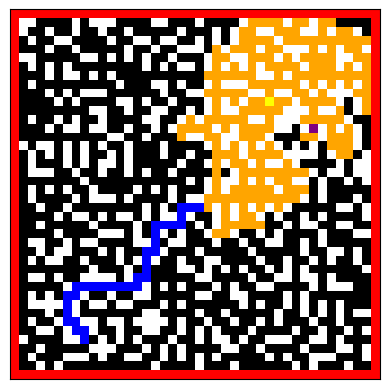

In [12]:
visualizeGrid(color_map_7, bot1Grid)

The yellow dot represents the source of the fire. The pink dot represents the button.

In [13]:
reset_grid(bot1Grid)

## Shortest Path (Bot 2)

In [14]:
def shortestBot2(grid, botLoc, fireLocs, butLoc, i, path):
    currentFires = set([])
    currentFires.add(fireLoc)
    for row in range(len(grid)):
        for col in range(len(grid[row])):
            if grid[row][col] == 3:
                currentFires.add((row, col))
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None
    success = False

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
            success = True
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4) and elt not in closed_set and elt not in currentFires:
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)
    if not success: 
        return path

    path2 = []
    curr = butLoc
#     print(prev1)
    while curr is not None:
        path2.append(curr)
        curr = prev1[curr]
    path2 = path2[::-1]
    if path2 != path[i:]:
        path[i:] = path2

    # Return the path from start to finish
    return path  # Reverse the path to go from start to finish

## Game Loop (Bot 2)

In [15]:
bot2Grid = copy.deepcopy(grid)
bot2Grid[fireLoc[0]][fireLoc[1]] = 3

def gameLoop2(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    grid[r][c] = 3
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    pathBot2 = []
    pathBot2.append(botLoc)
    pathBot2 = shortestBot2(bot2Grid, botLoc, fireLocs, butLoc, 0, pathBot2)
    i = 1
    while i < len(pathBot2):
        fireLocs = spreadFire(bot2Grid, fireLocs, q)
        if bot2Grid[pathBot2[i][0]][pathBot2[i][1]] == 3:
            if trackTime: 
                print(f"Bot2 failed in {t} timesteps.")
            success= False
            break
        bot2Grid[pathBot2[i][0]][pathBot2[i][1]] = 4
        pathBot2 = shortestBot2(bot2Grid, pathBot2[i], fireLocs, butLoc, i, pathBot2)
        t = t + 1
        i = i + 1
#     l = len(path)
    bot2Grid[butLoc[0]][butLoc[1]] = 5
    bot2Grid[fireLoc[0]][fireLoc[1]] = 6
    return success
success_2 = gameLoop2(bot2Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_2: print(f"Success!")

Bot2 failed in 35 timesteps.


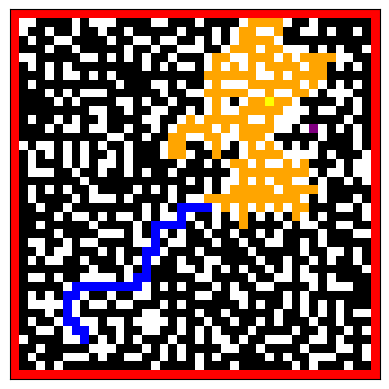

In [16]:
visualizeGrid(color_map_7, bot2Grid)

In [17]:
reset_grid(bot2Grid)

## Shortest Path (Bot 3)

In [18]:
def shortestBot3(grid, botLoc, fireLocs, butLoc, i, path):
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None
    success = False

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
            success = True
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4) and elt not in closed_set and (elt not in fireLocs or elt == butLoc):
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)
    if not success: 
        return path

    path2 = []
    curr = butLoc
#     print(prev1)
    while curr is not None:
        path2.append(curr)
        curr = prev1[curr]
    path2 = path2[::-1]
    if path2 != path[i:]:
        path[i:] = path2

    # Return the path from start to finish
    return path  # Reverse the path to go from start to finish

## Game Loop (Bot 3)

In [19]:
bot3Grid = copy.deepcopy(grid)
bot3Grid[fireLoc[0]][fireLoc[1]] = 3

def gameLoop3(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    grid[r][c] = 3
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    pathBot3 = []
    pathBot3.append(botLoc)
    pathBot3 = shortestBot3(bot3Grid, botLoc, fireLocs, butLoc, 0, pathBot3)
    i = 1
    while i < len(pathBot3):
        fireLocs = spreadFire(bot3Grid, fireLocs, q)
        if bot3Grid[pathBot3[i][0]][pathBot3[i][1]] == 3:
            if trackTime:
                print(f"Bot3 failed in {t} timesteps.")
            success= False
            break
        bot3Grid[pathBot3[i][0]][pathBot3[i][1]] = 4
        pathBot3 = shortestBot3(bot3Grid, pathBot3[i], fireLocs, butLoc, i, pathBot3)
        t = t + 1
        i = i + 1
#     l = len(path)
    bot3Grid[butLoc[0]][butLoc[1]] = 5
    bot3Grid[fireLoc[0]][fireLoc[1]] = 6
    return success

count = 0
for i in range(10):
    botLoc,butLoc,fireLoc = location_initialization(grid)
    reset_grid(bot3Grid)
    success = gameLoop3(bot3Grid, botLoc, fireLoc, butLoc, False, 1)
    print(success)
    if success:
        count += 1
print(count/10)

True
True
False
True
False
True
True
False
False
True
0.6


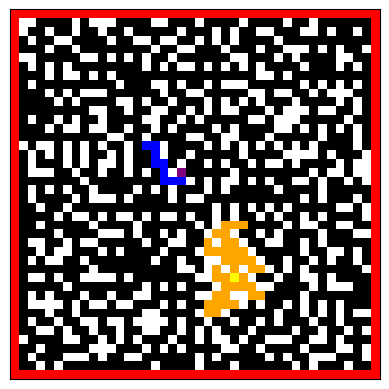

In [20]:
visualizeGrid(color_map_7, bot3Grid)

In [21]:
reset_grid(bot3Grid)

## Bot 4 Data Collection

In [35]:
def simulateFire(grid, fireLoc, df, numSims, q):
    r,c = fireLoc[0], fireLoc[1]
    for i in range(numSims):
        grid[r][c] = 3
        fireLocs = []
        fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
        t = 0
        while len(fireLocs) > 0:
            fireLocs = spreadFire(grid, fireLocs, q, df, i, t)
            t = t + 1
        reset_grid(grid)
    return df

In [23]:
def p(pt, df, t):
    return ((df.loc[pt] <= t).sum() / len(df.columns))

In [24]:
def d_manhattan(pt, butLoc):
    return abs(butLoc[0]-pt[0]) + abs(butLoc[1]-pt[1])

In [25]:
def C(pt, df, t, butLoc):
    return p(pt, df, t) + 0.1*d_manhattan(pt, butLoc)

In [26]:
import itertools
import pandas as pd

bot4Grid = copy.deepcopy(grid)
def simulateBot4(grid, fireLoc, q):
    numSims = 20
    cells = list(itertools.product(range(1, 41), repeat=2))
    df = pd.DataFrame(0, index=pd.MultiIndex.from_tuples(cells, names=["Row", "Col"]),
                      columns=[f'Sim_{i+1}' for i in range(numSims)])
    df = simulateFire(grid, fireLoc, df, numSims, q)
    return df

df = simulateBot4(bot4Grid, fireLoc, 0.5)
print(df.head())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [27]:
# Test it out
sampleLocation = (15,25)
print(f"Estimated cost of going to {sampleLocation} by 150 timesteps: {C(sampleLocation, df, 150, butLoc)}")

Estimated cost of going to (15, 25) by 150 timesteps: 1.9


## Shortest Path (Bot 4)

In [28]:
from queue import PriorityQueue as pq

def shortestBot4(grid, botLoc, butLoc, df):
    fringe4 = pq()
    fringe4.put((0.0, botLoc))

    dist = {}
    dist[botLoc] = 0

    prev4 = {}
    prev4[botLoc] = None
    
    time = {}
    time[botLoc] = 0

#     t = 1

    while fringe4.qsize() > 0:
        curr = fringe4.get()
        curr1 = curr[1]
        priority = curr[0]
        if curr1 == butLoc:
#             print("Success")
            break
        t = time[curr1]
        r1, c1 = curr1[0], curr1[1]
        neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
        for elt in neighbors1:
            if (elt[0] < 1 or elt[0] > 40) or (elt[1] < 1 or elt[1] > 40):
                continue
            elt_cost = C(elt, df, t+1, butLoc)
            if (bot4Grid[elt[0]][elt[1]] == 1 and (elt == butLoc or elt not in dist or elt_cost < dist[elt])):
                fringe4.put((elt_cost, elt))
                dist[elt] = elt_cost
                prev4[elt] = curr1
                time[elt] = t + 1

#         t = t + 1

    path4 = []
    curr = butLoc
    while curr is not None:
        path4.append(curr)
        curr = prev4[curr]

    # Return the path from start to finish
    return path4[::-1]

## Game Loop (Bot 4)

In [29]:
def gameLoop4(grid, botLoc, fireLoc, butLoc, trackTime, q):
    df = simulateBot4(grid, fireLoc, q=q)
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    path4 = []
    path4 = shortestBot4(bot4Grid, botLoc, butLoc, df)
    grid[r][c] = 3
    for i in path4[1:]:
        if i == path4[-1]:
            break
        fireLocs = spreadFire(bot4Grid, fireLocs, q=q)
        if bot4Grid[i[0]][i[1]] == 3:
            if trackTime: 
                print(f"Bot4 failed in {t} timesteps.")
            success= False
            break
        t = t + 1
        bot4Grid[i[0]][i[1]] = 4
    # l = len(path4)
    bot4Grid[butLoc[0]][butLoc[1]] = 5
    bot4Grid[fireLoc[0]][fireLoc[1]] = 6
    return success


success_4 = gameLoop4(bot4Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_4: print("Success!")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72

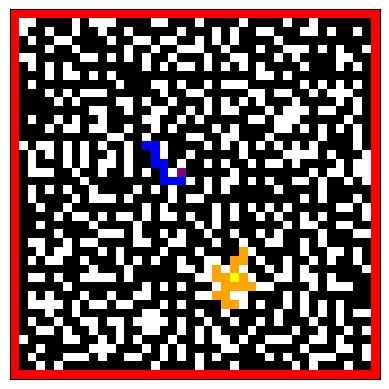

In [30]:
visualizeGrid(color_map_7, bot4Grid)

In [31]:
reset_grid(bot4Grid)

## Data Analysis

In [44]:
def does_path_exist(grid, fireLoc, butLoc, q):
    r,c = fireLoc[0], fireLoc[1]
    grid[fireLoc[0]][fireLoc[1]] = 3
    fireLocs = []
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    while grid[butLoc[0]][butLoc[1]] != 3:
        fireLocs = spreadFire(grid, fireLocs, q)
    
    fringe = []
    fringe.append(botLoc)
    closed_set = {}
    
    grid[butLoc[0]][butLoc[1]] = 1
    
    while len(fringe) > 0:
        curr1 = fringe.pop(0)
        if curr1 == butLoc:
            reset_grid(grid)
            return True
            
        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (bot1Grid[elt[0]][elt[1]] == 1 and elt not in closed_set) or elt == butLoc:
                    fringe.append(elt)
                    
    reset_grid(grid)
    return False
# botLoc,butLoc,fireLoc = location_initialization(grid)
# print(does_path_exist(grid, fireLoc, butLoc, 0.5))

In [50]:
# q_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
q_list = [0.1, 0.3, 0.5, 0.7, 0.9]
success_df_1 = pd.DataFrame(0, index=q_list, columns=['Bot1', 'Bot2', 'Bot3', 'Bot4'])
success_df_2 = pd.DataFrame(0, index=q_list, columns=['Bot1', 'Bot2', 'Bot3', 'Bot4'])
success_rates_bot4 = {}
numRounds = 100
only_bot_4 = []
file_path = 'simulations_1.csv'
# numGridsForTesting = 5
# grids_for_testing = []
#we would envelppe this in a for g in grids_for_testing and save the data both for the aggregate bot statistics and for per board basis if we think there might be anything cool, might take too long though
for q in q_list:
    success_rates_1 = [0.0,0.0,0.0,0.0]
    success_rates_2 = [0.0,0.0,0.0,0.0]
    counts_1 = [0,0,0,0]
    counts_2 = [0,0,0,0]
    counts_fail_bots = 0
    counts_bot4 = 0
    num_1 = 0
    for i in range(numRounds):
#         print(f"Run {i + 1} out of {numRounds} for q: {q}")
        
        grid_to_test = createBoard(d)
        botLoc,butLoc,fireLoc = location_initialization(grid_to_test)
        path_exists = does_path_exist(grid_to_test, fireLoc, butLoc, q)
        while not path_exists:
            botLoc,butLoc,fireLoc = location_initialization(grid_to_test)
            path_exists = does_path_exist(grid_to_test, fireLoc, butLoc, q)
#         visualizeGrid(color_map_3, grid_to_test)
#         print(f"Bot location: {botLoc}\nFire starts at: {fireLoc}\nButton location: {butLoc}")
        
        closer_to_fire = d_manhattan(botLoc, butLoc) >= d_manhattan(fireLoc, butLoc)
#         if closer_to_fire:
#             if num_1 < (numRounds // 2):
#                 num_1 += 1
#             else:
#                 while closer_to_fire:
#                     botLoc,butLoc,fireLoc = location_initialization(grid_to_test)
#                     path_exists = does_path_exist(grid_to_test, fireLoc, butLoc, q)
#                     while not path_exists:
#                         botLoc,butLoc,fireLoc = location_initialization(grid_to_test)
#                         path_exists = does_path_exist(grid_to_test, fireLoc, butLoc, q)
#                     closer_to_fire = d_manhattan(botLoc, butLoc) >= d_manhattan(fireLoc, butLoc)
    
        bot1Grid = copy.deepcopy(grid_to_test)
        bot2Grid = copy.deepcopy(grid_to_test)
        bot3Grid = copy.deepcopy(grid_to_test)
        bot4Grid = copy.deepcopy(grid_to_test)
        
        bot1_success_1 = gameLoop1(bot1Grid, botLoc, fireLoc, butLoc, False, q)
        bot1Grid = copy.deepcopy(grid_to_test)
        bot1_success_2 = gameLoop1(bot1Grid, fireLoc, botLoc, butLoc, False, q)
        bot2_success_1 = gameLoop2(bot2Grid, botLoc, fireLoc, butLoc, False, q)
        bot2Grid = copy.deepcopy(grid_to_test)
        bot2_success_2 = gameLoop2(bot2Grid, fireLoc, botLoc, butLoc, False, q)
        bot3_success_1 = gameLoop3(bot3Grid, botLoc, fireLoc, butLoc, False, q)
        bot3Grid = copy.deepcopy(grid_to_test)
        bot3_success_2 = gameLoop3(bot3Grid, fireLoc, botLoc, butLoc, False, q)
        bot4_success_1 = gameLoop4(bot4Grid, botLoc, fireLoc, butLoc, False, q)
        bot4Grid = copy.deepcopy(grid_to_test)
        reset_grid(bot4Grid)
        bot4_success_2 = gameLoop4(bot4Grid, fireLoc, botLoc, butLoc, False, q)
        
        
            
        # Run on a board configuration twice per round, switching fire and bot positions to ensure even spread of fire closer to button vs bot closer to button
        if bot1_success_1:
            if closer_to_fire:
                counts_1[0] += 1 
            else: counts_2[0] += 1
        if bot1_success_2:
            if closer_to_fire:
                counts_2[0] += 1 
            else: counts_1[0] += 1
#         print("Bot 1 Done")

        if bot2_success_1:
            if closer_to_fire:
                counts_1[1] += 1 
            else: counts_2[1] += 1
        if bot2_success_2:
            if closer_to_fire:
                counts_2[1] += 1 
            else: counts_1[1] += 1
#         print("Bot 2 Done")


        if bot3_success_1:
            if closer_to_fire:
                counts_1[2] += 1 
            else: counts_2[2] += 1
        if bot3_success_2:
            if closer_to_fire:
                counts_2[2] += 1 
            else: counts_1[2] += 1
#         print("Bot 3 Done")


        if bot4_success_1:
            if closer_to_fire:
                counts_1[3] += 1 
            else: counts_2[3] += 1
        if bot4_success_2:
            if closer_to_fire:
                counts_2[3] += 1 
            else: counts_1[3] += 1
#         print("Bot 4 Done")

        if not (bot1_success_1 or bot2_success_1 or bot3_success_1):
            counts_fail_bots += 1
            if bot4_success_1:
                counts_bot4 += 1
                only_bot_4.append(bot4Grid)
#                 visualizeGrid(color_map_7, bot4Grid)
        if not (bot1_success_2 or bot2_success_2 or bot3_success_2):
            counts_fail_bots += 1
            if bot4_success_2:
                counts_bot4 += 1
                only_bot_4.append(bot4Grid)
#                 visualizeGrid(color_map_7, bot4Grid)
#         if bot1_success and bot2_success and bot3_success and not bot4_success:
#             visualizeGrid(color_map_7, bot4Grid)
        
    
                
    for bot in range(len(counts_1)):
        success_rates_1[bot] = counts_1[bot]/(numRounds)
        success_rates_2[bot] = counts_2[bot]/(numRounds)
    success_df_1.loc[q] = success_rates_1
    success_df_2.loc[q] = success_rates_2
    if counts_fail_bots == 0:
        success_rates_bot4[q] = 0.0
    else: success_rates_bot4[q] = counts_bot4/counts_fail_bots
    
    print(f"Success rates, button starts closer to fire: \n{success_df_1.loc[q]}")
    print(f"Success rates, button starts closer to bot: \n{success_df_2.loc[q]}")
    print(f"Success rate of bot 4 given that all other bots failed, q = {q}: \n{success_rates_bot4[q]}")
    print()
success_df_1.to_csv(file_path)
success_df_2.to_csv(file_path.replace("simulations_1.csv", "simulations_2.csv"))

# Save the success_rates_bot4 dictionary as a CSV
success_rates_bot4_df = pd.DataFrame(list(success_rates_bot4.items()), columns=['q', 'SuccessRate_Bot4'])
success_rates_bot4_df.to_csv(file_path.replace("simulations_1.csv", "bot4_success_rates.csv"), index=False)

Success rates, button starts closer to fire: 
Bot1    0.000000
Bot2    0.333333
Bot3    0.666667
Bot4    0.333333
Name: 0.1, dtype: float64
Success rates, button starts closer to bot: 
Bot1    1
Bot2    1
Bot3    1
Bot4    1
Name: 0.1, dtype: int64
Success rate of bot 4 given that all other bots failed, q = 0.1: 
0.0

Success rates, button starts closer to fire: 
Bot1    0.333333
Bot2    0.333333
Bot3    0.000000
Bot4    0.333333
Name: 0.3, dtype: float64
Success rates, button starts closer to bot: 
Bot1    1
Bot2    1
Bot3    1
Bot4    1
Name: 0.3, dtype: int64
Success rate of bot 4 given that all other bots failed, q = 0.3: 
0.0

Success rates, button starts closer to fire: 
Bot1    0.000000
Bot2    0.333333
Bot3    0.000000
Bot4    0.333333
Name: 0.5, dtype: float64
Success rates, button starts closer to bot: 
Bot1    1
Bot2    1
Bot3    1
Bot4    1
Name: 0.5, dtype: int64
Success rate of bot 4 given that all other bots failed, q = 0.5: 
0.5

Success rates, button starts closer to f

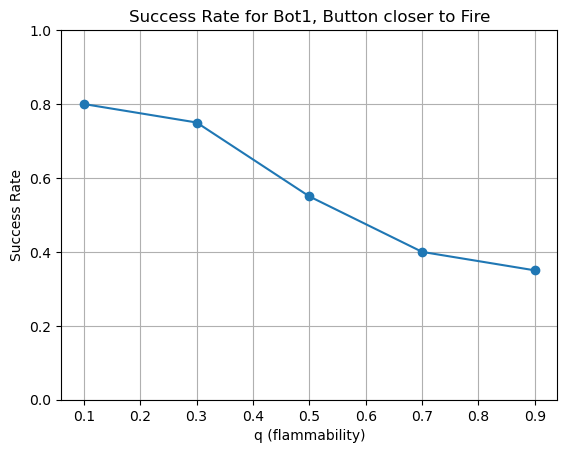

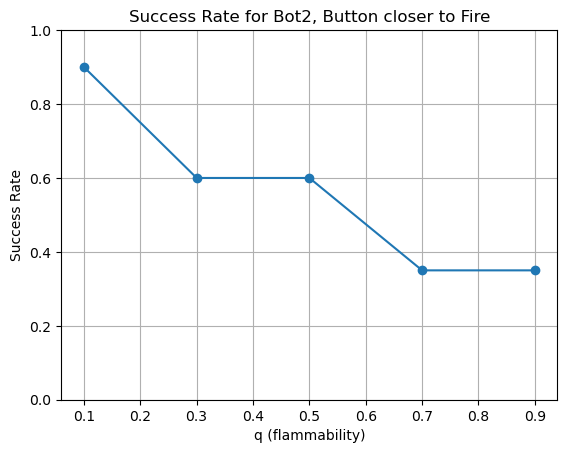

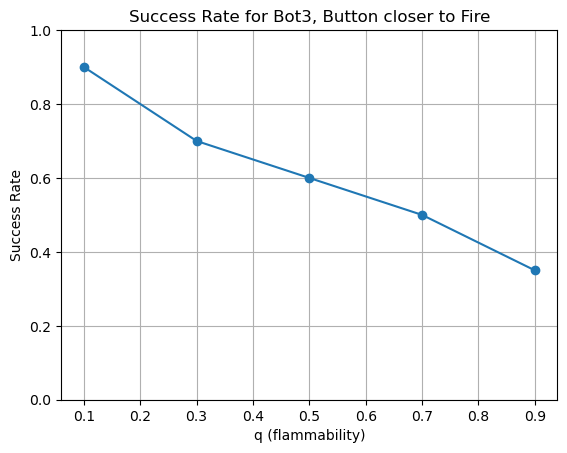

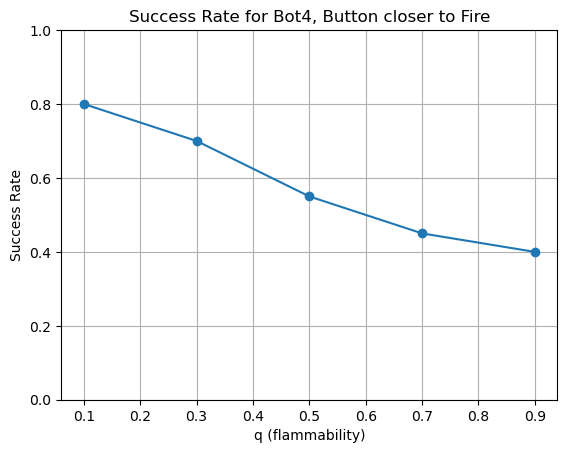

In [40]:
# Plotting for each bot, Button closer to Fire
for bot in ['Bot1', 'Bot2', 'Bot3', 'Bot4']:
    plt.figure()  # Create a new figure for each bot
    plt.plot(q_list, success_df_1[bot], marker='o')
    
    # Add labels and title
    plt.title(f'Success Rate for {bot}, Button closer to Fire')
    plt.xlabel('q (flammability)')
    plt.ylabel('Success Rate')
    
    plt.ylim(0,1)
    
    # Show the grid for clarity
    plt.grid(True)
    
    # Show the plot
    plt.show()


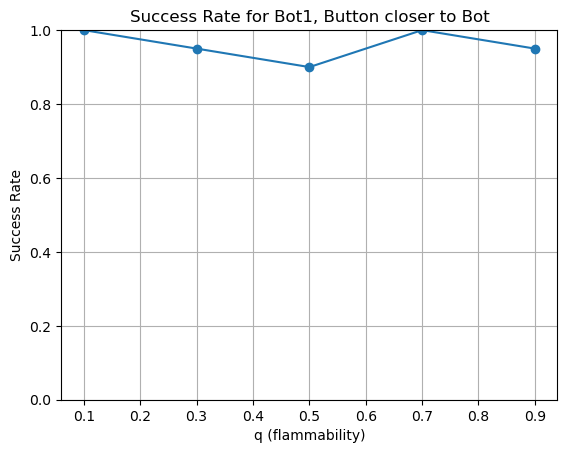

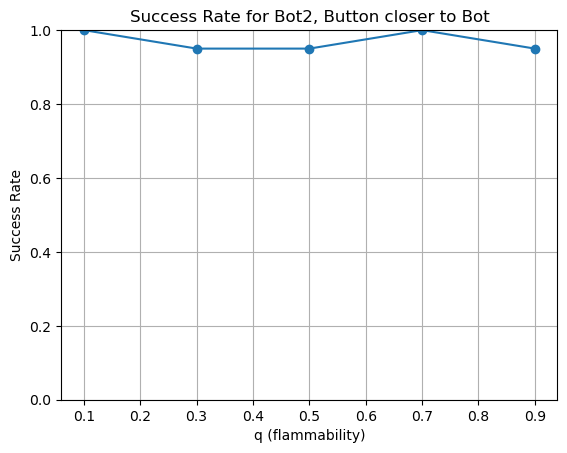

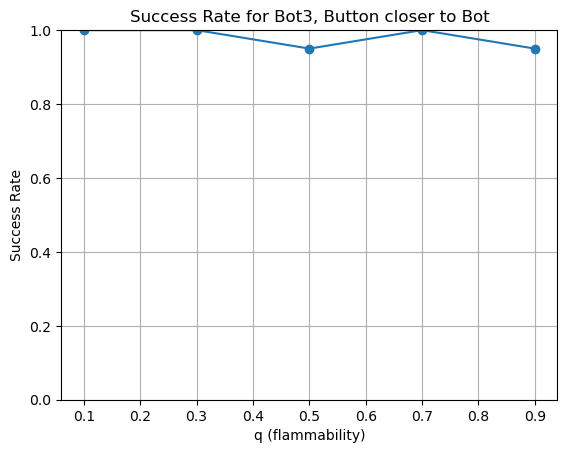

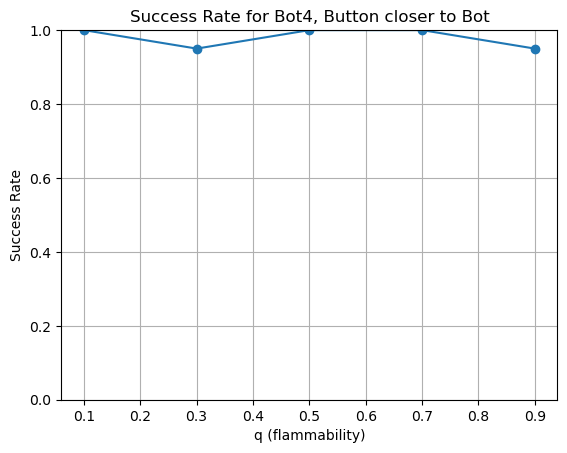

In [41]:
# Plotting for each bot, button closer to bot
for bot in ['Bot1', 'Bot2', 'Bot3', 'Bot4']:
    plt.figure()  # Create a new figure for each bot
    plt.plot(q_list, success_df_2[bot], marker='o')
    
    # Add labels and title
    plt.title(f'Success Rate for {bot}, Button closer to Bot')
    plt.xlabel('q (flammability)')
    plt.ylabel('Success Rate')
    
    plt.ylim(0,1)
    
    # Show the grid for clarity
    plt.grid(True)
    
    # Show the plot
    plt.show()

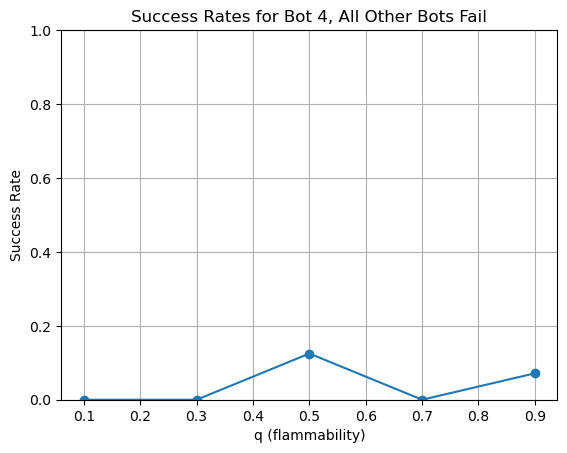

In [42]:
# Plotting for bot 4 success rate, all other bots failed
plt.figure()  # Create a new figure for each bot
success_rates = [success_rates_bot4[q] for q in q_list]
plt.plot(q_list, success_rates, marker='o')

# Add labels and title
plt.title(f'Success Rates for Bot 4, All Other Bots Fail')
plt.xlabel('q (flammability)')
plt.ylabel('Success Rate')

plt.ylim(0,1)

# Show the grid for clarity
plt.grid(True)

# Show the plot
plt.show()

## Results & Discussion

We separated our results into 2 bins: those for which the button was closer to the bot, and those for which the button was closer to the fire. Each bot showed a consistently high success rate for the former bin regardless of $q$; for the second bin, each bot's success rate decreased as $q$ increased. We ignored all cases where no path was possible.
What was particularly interesting were the cases in which all bots failed except bot 4. We display all such cases. The success rate of bot 4 given all other bots failed showed no trend as $q$ increased, so we'll have to examine it on a case-by-case basis. 